# Speech Emotion Recognition Using RNN

In [ ]:
from google.colab import drive
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

# Directory containing audio files in Google Drive
data_dir = '/content/drive/MyDrive/TESS Toronto emotional speech set data'

# Function to extract features from audio files
def extract_features(file_path, mfcc=True, chroma=True, mel=True):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)
        # Extract features
        features = []
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
            features.extend(mfccs)
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
            features.extend(chroma)
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
            features.extend(mel)
        return features
    except Exception as e:
        print("Error encountered while processing {}: {}".format(file_path, e))
        return None

# Lists to store features and labels
features = []
labels = []

# Loop through audio files and extract features
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.wav'):  # Assuming the audio files are in WAV format
            file_path = os.path.join(root, file)
            emotion_label = root.split('/')[-1]  # Assuming emotion labels are folder names
            extracted_features = extract_features(file_path)
            if extracted_features is not None:
                features.append(extracted_features)
                labels.append(emotion_label)

# Convert lists to NumPy arrays
X = np.array(features)
y = np.array(labels)

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, X_train and y_train contain the training features and labels,
# and X_test and y_test contain the testing features and labels, respectively.

Mounted at /content/drive


# Preprocessing Data for RNN input

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)


# Reshape features for LSTM input (assuming each feature vector is a time step)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
print(X_train_lstm.shape)

(2240, 1, 153)


# build an RNN model using libraries like Keras

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Build a more complex LSTM model
model = Sequential()

# Add a Bidirectional LSTM layer with 128 units and dropout for regularization
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.2))

# Add another Bidirectional LSTM layer with 64 units and dropout for regularization
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))

# Add a Dense layer with 64 units
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Add the output layer with the number of classes (emotions) and softmax activation
num_classes = len(label_encoder.classes_)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss function
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with a larger number of epochs and a smaller batch size
history = model.fit(X_train_lstm, y_train_categorical,
          epochs=50,
          batch_size=16,
          validation_data=(X_test_lstm, y_test_categorical), callbacks=[early_stopping])

Epoch 1/50
140/140 [==============================] - 15s 18ms/step - loss: 1.3373 - accuracy: 0.4835 - val_loss: 0.5904 - val_accuracy: 0.7714
Epoch 2/50
140/140 [==============================] - 1s 8ms/step - loss: 0.5603 - accuracy: 0.7879 - val_loss: 0.3700 - val_accuracy: 0.8571
Epoch 3/50
140/140 [==============================] - 1s 9ms/step - loss: 0.3287 - accuracy: 0.8799 - val_loss: 0.3315 - val_accuracy: 0.8786
Epoch 4/50
140/140 [==============================] - 1s 8ms/step - loss: 0.2892 - accuracy: 0.8964 - val_loss: 0.2094 - val_accuracy: 0.9250
Epoch 5/50
140/140 [==============================] - 1s 8ms/step - loss: 0.2287 - accuracy: 0.9183 - val_loss: 0.4536 - val_accuracy: 0.8643
Epoch 6/50
140/140 [==============================] - 1s 8ms/step - loss: 0.1984 - accuracy: 0.9272 - val_loss: 0.1409 - val_accuracy: 0.9500
Epoch 7/50
140/140 [==============================] - 1s 11ms/step - loss: 0.2043 - accuracy: 0.9210 - val_loss: 0.1383 - val_accuracy: 0.9554
Epo

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 256)            288768    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

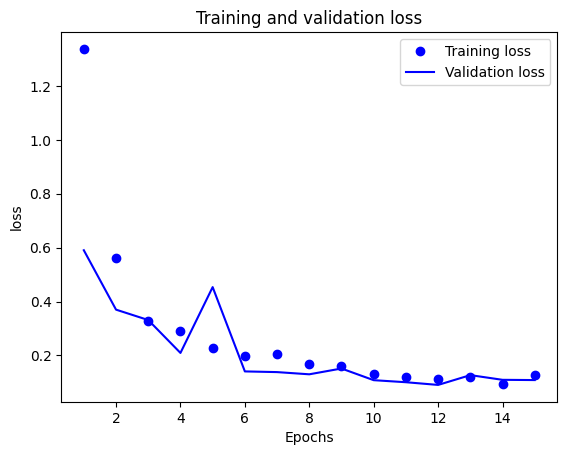

In [ ]:
# Plotting training and validation loss
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

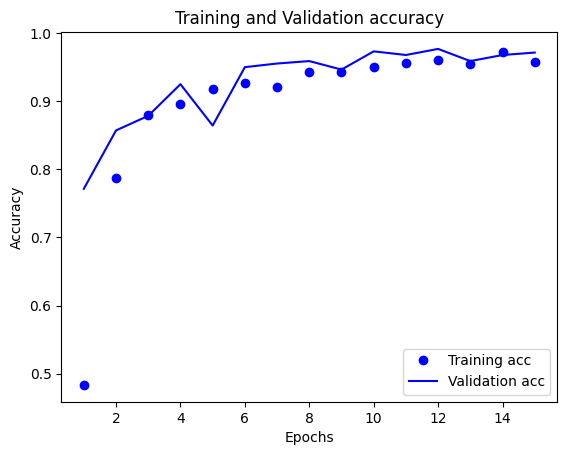

In [ ]:
# Plotting training and validation accuracy
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In this model:

<b>Bidirectional LSTM Layers:</b> Bidirectional LSTMs process the input sequence in both forward and backward directions, which can capture more complex patterns in the data.

<b>Dropout Layers:</b> Dropout layers are added after each LSTM layer to prevent overfitting. Dropout randomly sets a fraction of input units to 0 at each update during training, which helps prevent overfitting.

<b>Dense Layers:</b> Additional dense layers with ReLU activation functions are added to learn high-level features from the output of LSTM layers.

<b>Early Stopping:</b> Early stopping is implemented to monitor the validation loss and stop training when the loss stops decreasing, which helps prevent overfitting.

<b>Adam Optimizer:</b> Adam optimizer is used with a learning rate of 0.001, which is a popular choice for deep learning tasks.

# Predicting

In [ ]:
from IPython.display import Audio

audio_file_path = actual path  # Replace with the actual path to your audio file
Audio(audio_file_path)

In [ ]:
def Predictions(file_path):
  pred_feature = []
  pred_features = extract_features(file_path)
  pred_feature.append(pred_features)
  Pred_X = np.array(pred_feature)
  X_pred_lstm = Pred_X.reshape(Pred_X.shape[0], 1, Pred_X.shape[1])
  pred = model.predict(X_pred_lstm)
  predicted_label_index = np.argmax(pred)
  predicted_label = label_encoder.classes_[predicted_label_index]

  print("Predicted Label:", predicted_label)

In [ ]:
Predictions('audio/file/path')

# For UI Implementations
For UI, we will take input from the user to predict the emotions. So as to use this model, we will save it using the PICKLE library.

In [ ]:
import pickle

# Save the entire model
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
from google.colab import files

# Download the model file to your local machine
files.download('model.pkl')

In [ ]:
model.save('BiLstm_model.h5')

In [ ]:
model.save('BiLstm_model.keras')